In [5]:
import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy
import networkx as nx
import sys
sys.path.insert(0, 'utils/')
from GR_Maze_Utils import *
from GR_RL_Utils import *

from matplotlib import rc
rc('text', usetex=True)

%load_ext autoreload
%autoreload 2

np.set_printoptions(suppress=True, precision = 4)

from scipy.special import gammainc
from scipy.stats import norm
from scipy.special import lambertw
from scipy.special import factorial

def sig(x):
    return 1.0/(1.0 + np.exp(-x))

def ser(t,m):
    return np.exp(m*np.log(t+1e-8) - t - np.log(factorial(m)))

np.random.seed(0)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [16]:
def create_linear_track(L):
    G = nx.DiGraph()
    G.add_nodes_from([('0')])
    G.add_nodes_from([(str(L))])
    for l in range(1,L):
        G.add_nodes_from([(str(l))])
        G.add_nodes_from([(str(l)+'b')])
    index = 0
    for l in range(L):
        G.add_edges_from([(str(l),str(l+1),{'Qe':0, 'Qr':0, 'V':0, 'R':0, 'i':index}),(str(l+1),str(l),{'Qe':0, 'Qr':0, 'V':0,'R':0, 'i':index+1})])
        index += 2
        
    for l in range(1,L):
        G.add_edges_from([(str(l)+'b',str(l),{'Qe':0, 'Qr':0, 'V':0, 'R':0, 'i':index}),(str(l),str(l)+'b',{'Qe':0, 'Qr':0, 'V':0,'R':0, 'i':index+1})])
        index += 2
    
    return G

def get_transition_matrix_linear(L): 
    G = create_linear_track(L)
    index_to_state = get_index_to_state_vec(G)
    
    S = len(index_to_state)
    A = 2 
    #if on main branch, a= 0 continue along main branch, a = 1 branch out
    #if coming out of branch, a = 0 go towards start, a = 1 go towards goal
    #if going into branch, you come out regardless. 
    Tmat = np.zeros((S,A,S)) + 1e-6 #add small constant to avoid dividing by zero downstream. 
    for s in range(S):
        state = index_to_state[s]
        n1 = state[0]
        n2 = state[1]
        for a in range(A):
            if n2[-1] == 'b' or n2 == str(L) or n2 == str(0): #reflecting BC
                n3 = deepcopy(n1)
            elif n1[-1] == 'b': #coming out of branch
                n3 = str(int(n2) - 1 + 2*a)
            elif int(n2) > int(n1): #going towards goal on main branch
                if a == 0:
                    n3 = str(int(n2) + 1)
                if a == 1:
                    n3 = n2 + 'b'
            elif int(n2) < int(n1): #going towards start on main branch
                if a == 0:
                    n3 = str(int(n2) - 1)
                if a == 1:
                    n3 = n2 + 'b'
                    
            nextstate = (n2,n3)
            
            #print(a,n1,n2,n3)
            nextstate_index = get_state_index(nextstate,G)
            Tmat[s,a,nextstate_index] = 1
            
    Tmat /= np.sum(Tmat,axis=-1)[:,:,None]
    return Tmat

def initialize_Q(G,eps,eps2): #set exploration probabilities via Qe
    p_d = 1.0/(1.0 + np.exp(-eps)) #prob of continuing towards goal when going towards goal on main branch
    p_u = 0.5 #prob of continuing towards start when going towards start on main branch
    r_u = 1.0/(1.0 + np.exp(eps2)) #prob of going towards start when coming out of branch
    
    index_to_state = get_index_to_state_vec(G)
    
    S = len(index_to_state)
    A = 2 
    
    for s in range(S):
        state = index_to_state[s]
        n1 = state[0]
        n2 = state[1]
        
        G[state[0]][state[1]]['Qr'] = np.zeros(A)
        G[state[0]][state[1]]['Qe'] = np.zeros(A)
        G[state[0]][state[1]]['Qe'][1] = 0
        eps = 0
        
        if n2[-1] == 'b' or n2 == str(L) or n2 == str(0): #reflecting BC
            eps = 0
        elif n1[-1] == 'b': #coming out of branch
            eps = np.log(r_u/(1-r_u))
        elif int(n2) > int(n1):#going towards goal on main branch
            eps = np.log(p_d/(1-p_d))
        elif int(n2) < int(n1):#going towards start on main branch
            eps = np.log(p_u/(1-p_u))  
                
        G[state[0]][state[1]]['Qe'][0] = eps
        
    return G

def get_pp_pn(eps,eps2,eps3):
    pp = sig(eps) + (1-sig(eps))*sig(eps2)
    pn = sig(eps3) + (1-sig(eps3))*(1-sig(eps2))
    return pp,pn
    
def get_qs_numerics(r,L,N,eps,eps2, q_mem = 1, alpha = 0.05, gam = 1):
    qs = np.zeros((L,N))
    qs[-1] = r

    ss = np.zeros((L,N))
    
    indices = np.zeros(L-1, dtype=int)
    for l in range(L-1):
        indices[l] = min(l + q_mem,L-1)
        

    for n in range(1,N):
        sigq = sig(eps+qs[:-1,n-1])
        sigs = sig(eps2+ss[:-1,n-1])
        
        
        prods = np.zeros(L-1)
        for l in range(L-1):
            prods[l] = np.prod(sig(eps+qs[l+1:indices[l]+1,n-1]))
        
        rho =  sigq/((1-sigq)*sigs + sigq)

        qs[:-1,n] = qs[:-1,n-1] + alpha*(-qs[:-1,n-1] + gam*qs[indices,n-1]*prods)*rho
        ss[:-1,n] = ss[:-1,n-1] + alpha*(-ss[:-1,n-1] + gam*qs[indices,n-1]*prods)*(1-rho)
    return qs,ss
    
    
def get_lf(tau):
    return (-1/tau)*lambertw(-tau*np.exp(-tau),0).real

def get_speed_pred(eps,r,k):
    if eps <= 0:
        if k==0:
            v = r/(r + np.exp(-eps) - 1)
        else:
            taus = np.linspace(1.01/(1+k),1.5,500)
            tauks = np.zeros(len(taus))
            for i,tau in enumerate(taus):
                beta = 1 - get_lf((1+k)*tau)
                g0 = abs(eps)/r
                tauk = (-eps + np.exp(-eps)-1)/r +  (1-g0)*(np.exp(-k*tau*beta) - np.exp(-(k+1)*tau*beta))/beta
                tauks[i] = tauk
            tauk = taus[np.argmin(np.abs(tauks-taus))]
            v = 1/tauk
    else:
        v = 1+k
    return min(1+k,v)

def get_speed_numerics(L,eps,eps2,r,q_mem = 1, alpha = 0.01,gam = 1 - 1e-5, plot =False):
    vest = sig(eps + np.log(r))*alpha*q_mem
    N = int(1.05*L/vest)

    qs,ss = get_qs_numerics(r,L,N,eps,eps2,q_mem = q_mem, alpha = alpha, gam = gam)

    mins = np.argmin(np.abs(qs - np.max(qs,axis=0)[None,:]/2),axis=0)
    p = np.polyfit(np.arange(len(mins[int(0.1*N):-int(0.1*N)])),mins[int(0.1*N):-int(0.1*N)],1)
    if plot:
        plt.close("all")
        fig,axis = plt.subplots(1,1,figsize = (3,3))
        axis.plot(np.arange(len(mins[int(0.1*N):-int(0.1*N)])),mins[int(0.1*N):-int(0.1*N)])
        axis.plot(L-1 - alpha*np.arange(N))

        axis.plot(p[0]*np.arange(len(mins[int(0.1*N):-int(0.1*N)])) + p[1])
        plt.show()

    return -p[0]/alpha

def get_speed_sarsa(L,eps,eps2,r,alpha = 0.1,gam = 1 - 1e-5, q_mem_size = 1, lamb = None, plot = False):
    # Learning parameters
    
    rew = r
    if q_mem_size <= 1:
        lamb = 0
    elif lamb is None:
        lamb = 1

    niter = 50000
    nepi = int(8*L/alpha)
    
    G, Qrs, time_rews, cum_rews = run_RL_simulation(nepi,niter,L,lamb = lamb,\
                        alpha = alpha,gam=gam,rew = rew, mode=2, eps = eps, eps2=eps2, q_mem_size = q_mem_size)
    
    nepi = len(Qrs)
    mins = np.argmin(np.abs(Qrs[int(0.1*nepi):,:,0,0] - np.max(Qrs[int(0.1*nepi):,:,0,0],axis=1)[:,None]/2),axis=1)

    #print(mins)
    p = np.polyfit(np.arange(len(mins[:])),mins[:],1)
    if plot:
        plt.close("all")
        plt.plot(mins)
        plt.plot(L-1 - alpha*np.arange(len(mins)))

        plt.plot(p[0]*np.arange(len(mins[:])) + p[1])
        plt.show()
    return -p[0]/alpha

In [7]:
def set_Q_BCs(G):
    index_to_state = get_index_to_state_vec(G)
    
    S = len(index_to_state)
    A = 2
    for s in range(S):
        state = index_to_state[s]
        n1 = state[0]
        n2 = state[1]
        eps = 0
        if n2[-1] == 'b' or n2 == str(L) or n2 == str(0): #reflecting BC
            G[n1][n2]['Qr'] = np.zeros(A)
        elif n1[-1] == 'b': #coming out of branch
            True
        elif int(n2) > int(n1):#going towards goal on main branch
            G[n1][n2]['Qr'][1] = 0
        elif int(n2) < int(n1):#going towards start on main branch
            G[n1][n2]['Qr'][1] = 0
    return G

def detect_side_path(state):
    if state[1][-1] == 'b':
        return True
    else:
        return False
        
    
def get_Qvalues(G,L):
    Qrs = np.zeros((L-1,2,2))
    for i in range(L-1):
        Qrs[i,:,0] = G[str(i)][str(i+1)]['Qr']
        Qrs[i,:,1] = G[str(i+1)+'b'][str(i+1)]['Qr']
        
    Qes = np.zeros((L-1,2,2))
    for i in range(L-1):
        Qes[i,:,0] = G[str(i)][str(i+1)]['Qe']
        Qes[i,:,1] = G[str(i+1)+'b'][str(i+1)]['Qe']
        
    return Qrs, Qes

def run_RL_simulation(nepi,niter,L, alpha = 0.01, gam = 0.98,lamb = 0.8, goal = ('2','3'),\
                     rew = 20,mode = 0, eps = 0, eps2= 0, q_mem_size = None, dyna_mem_size = 500, dyna_plan_steps = 10):
    #Initialize setup

    #generate graph and get Q values
    G = create_linear_track(L)
    Tmat = get_transition_matrix_linear(L)
    index_to_state = get_index_to_state_vec(G)
    
    S = len(index_to_state)
    A = 2

    G = initialize_Q(G,eps,eps2)
    
    goal = (str(L-1),str(L))

    #initialize environment

    rew_timer = 0
    G[goal[0]][goal[1]]['R'] = rew

    nodes = ['0']
    
    if q_mem_size is None:
        q_mem_size = int(2.5/(1-lamb))

    rews_received = 0
    cum_rews = []
    time_rews = []
    
    params = [alpha,gam,lamb]
    
    if mode == 3:
        params += [dyna_plan_steps]
    
    dyna_mem = []
    
    Qr_stored = np.zeros((nepi,L-1,2,2))

    for epi in range(nepi):
        #initialize state
        n0 = str(0)
        n1 = str(1)
        state = (n0,n1) 

        nodes += [state[1]]

        q_mem = []
        
        sasr_seq = []

        
        G = set_Q_BCs(G)
        
        for i in range(niter):
            rew_timer += 1
            s_index = get_state_index(state,G)
            if mode == 4:
                a = get_explo_action(state,G)
            else:
                a = get_action(state,G)
            #a=0
            s_next = get_next_state(s_index,a,Tmat)
            prevstate = deepcopy(state)
            state = index_to_state[s_next]
            curr_rew = G[state[0]][state[1]]['R']

            nodes += [state[1]]
            
            sasr = [prevstate, a, state, curr_rew]
            
            if mode == 3:
                sasr_seq += [sasr]
                #dyna_mem = update_memory_dyna(dyna_mem, sasr, dyna_mem_size)
            else:
                q_mem = update_memory_q(q_mem, sasr, q_mem_size)
                if detect_side_path(state):
                    q_mem = []
            
            if mode == 0:
                G = update_Q_sQ(q_mem,sasr,goal,G,params) #sQ
            elif mode == 1 or mode == 4:
                G = update_Q_Q(q_mem,sasr,goal,G,params) #Q or Q(explo)
            elif mode == 2:
                G = update_Q_sarsa(q_mem,sasr,goal,G,params) #sarsa
            elif mode == 3:
                G = update_Q_dyna(dyna_mem,sasr,goal,G,params) #dyna
            
            
            #print("%03d   %03d   " %(epi, i), state[0],state[-1])

            if state == goal:
                rews_received += 1
                cum_rews += [rews_received]
                time_rews += [rew_timer] 
                break
                
        if mode == 3:
            dyna_mem = update_memory_dyna(dyna_mem, sasr_seq, dyna_mem_size)
                
        Qr_stored[epi] = get_Qvalues(G,L)[0]
        if G['0']['1']['Qr'][0] > rew*0.5:
            nepi = epi+1
            Qr_stored = Qr_stored[:nepi]
            break
            
    return G, Qr_stored, time_rews, cum_rews
        
def get_direct_paths(time_rews,L):
    time_paths = [0]
    cum_paths = [0]
    for i in range(len(time_rews)-1):
        dt = time_rews[i+1] -  time_rews[i]
        if dt == L-1:
            time_paths += [time_rews[i+1]]
            cum_paths += [cum_paths[-1] + 1]
    return time_paths, cum_paths

### Run RL simulation on linear track (SARSA with ET)

3058
nepi: 3058  vsim:  1.30  vnum:  1.38 


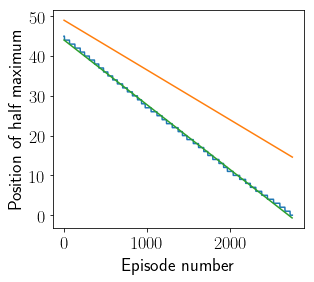

In [8]:
np.random.seed(0)
# Learning parameters
alpha = 0.0125 #learning rate
gam = 0.9999 #discount factor
rew = 15
eps = -2
eps2 = 10
L = 50 #length of track
lamb = 1.0 #eligibility traces
q_mem = 3

niter = 50000 #large enough that agent reaches reward in each episode. 
nepi = int(4*L/alpha) #large enough that learning converges. 
#the simulation automatically stops when the wave reaches the start.

mode = 2

G, Qrs, time_rews, cum_rews = run_RL_simulation(nepi,niter,L,lamb = lamb,\
                        alpha = alpha,gam=gam,rew = rew,mode=mode, eps=eps,eps2=eps2, q_mem_size = q_mem)
time_paths, cum_paths = get_direct_paths(time_rews,L)


#Measure speed of wave.
#This tracks the position of the half maximum of the reward after each episode.  

nepi = len(Qrs)
print(nepi)
mins = np.argmin(np.abs(Qrs[int(0.1*nepi):,:,0,0] - np.max(Qrs[int(0.1*nepi):,:,0,0],axis=1)[:,None]/2),axis=1)
p = np.polyfit(np.arange(len(mins[1:])),mins[1:],1)
vsim = -p[0]/alpha

#Prediction from numerics as a consistency check
eps = G['0']['1']['Qe'][0]
eps2 = -G['1b']['1']['Qe'][0]
vnum = get_speed_numerics(L,eps,eps2,rew, alpha = alpha, gam = gam,q_mem = q_mem, plot = False)
print("nepi: %d  vsim:  %.2f  vnum:  %.2f "%(nepi, vsim, vnum))

plt.close("all")
fig,axis = plt.subplots(1,1,figsize = (4.5,4))
axis.plot(mins)
axis.plot(L-1 - alpha*np.arange(len(mins))) #speed of 1. 
axis.plot(p[0]*np.arange(len(mins[3:])) + p[1])
axis.set_xlabel("Episode number",fontsize = 18)
axis.set_ylabel("Position of half maximum",fontsize = 18)
axis.tick_params(labelsize = 18)
plt.show()

In [9]:
eps = G['0']['1']['Qe'][0]
eps2 = -G['1b']['1']['Qe'][0]
eps3 = G['1']['0']['Qe'][0]

r = rew
N = nepi

qs,ss = get_qs_numerics(r,L,N,eps,eps2,q_mem = q_mem, alpha = alpha)
#print(alpha,r,L,N,eps,eps2)

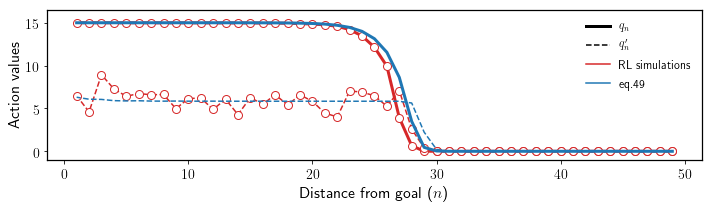

In [11]:
plt.close("all")
fig,axis = plt.subplots(1,1,figsize = (10,3))
epis = [int(20/alpha)]
colors_Q = ['C3']
colors_q = ['C0']
alphas = [1.0]
locs = [5.5]

xs = np.arange(L-1,0,-1)
#print(len(xs),len(qs),len(Qrs[e,:,0,0]))

for i,e in enumerate(epis):
    axis.plot(xs,Qrs[e,:,0,0],'o-',lw = 3,ms = 8, mec=colors_Q[i],mfc = 'w', color = colors_Q[i],alpha = alphas[i])
    axis.plot(xs,Qrs[e,:,1,1], 'o--', lw = 1.5,ms = 8,mec=colors_Q[i],mfc = 'w', color = colors_Q[i],alpha = alphas[i])
    axis.plot(xs,qs[:-1,e],'-', lw = 3, color = colors_q[i])
    axis.plot(xs,ss[:-1,e], '--',lw = 1.5, color = colors_q[i])
    
    
axis.plot([],[],'k-',lw=3,label = r"$q_n$")
axis.plot([],[],'k--',lw=1.5,label = r"$q_n'$")
axis.plot([],[],'C3-',lw=1.5,label = "RL simulations")
axis.plot([],[],'C0-',lw=1.5,label = "eq.49")
axis.legend(fontsize = 12,frameon=False)

#axis.set_title("Episode: %d"%i,fontsize= 15)
axis.tick_params(labelsize = 14)
axis.set_ylim(-1,np.max(Qrs)*1.1)
#axis.set_xticks([])
axis.set_xlabel(r"Distance from goal ($n$)",fontsize = 16)
axis.set_ylabel(r"Action values",fontsize= 16)
for sp in ['top','bottom','left','right']:
    axis.spines[sp].set_linewidth(1.25)
fig.tight_layout()
fig.savefig("./plots/et_compare_sim_num.pdf")
plt.show()

### Speed vs k 

In [32]:
np.random.seed(0)
r = 25
L = 35
alpha = 0.00625
N = int(2.5*L/alpha)
eps2 = 10

epss = [-1.5,-3,-3]
rs = [25,25,50]

q_mems = np.arange(1,9)

vnums = np.zeros((len(epss),len(q_mems)))
vsarsas = np.zeros((len(epss),len(q_mems)))
vpreds = np.zeros((len(epss),len(q_mems)))

vlambdas = np.zeros((len(epss),len(q_mems)))

for j in range(len(epss)):
    eps = epss[j]
    r = rs[j]
    for i,q_mem in enumerate(q_mems):
        k = q_mem - 1

        vsarsa = get_speed_sarsa(L,eps,eps2,r,alpha = alpha,gam = 1 - 1e-5, q_mem_size = q_mem, plot = False)
        vnum = get_speed_numerics(L,eps,eps2,r, alpha = alpha, gam = 1, q_mem = q_mem, plot = False)
        vpred = get_speed_pred(eps,r,k)
        
        if q_mem == 1:
            lamb = 0
            vlambda = get_speed_sarsa(L,eps,eps2,r,alpha = alpha,gam = 1 - 1e-5, q_mem_size = 1, plot = False)
        else:
            vlambda = get_speed_sarsa(L,eps,eps2,r,alpha = alpha,gam = 1 - 1e-5,\
                                            q_mem_size = 4*q_mem, lamb = 1 - 1/q_mem, plot = False)

        vnums[j,i] = vnum
        vpreds[j,i] = vpred
        vsarsas[j,i] = vsarsa
        vlambdas[j,i] = vlambda

        print("%.3f  %.3f   %.3f   %.3f" %(vpred, vnum, vsarsa, vlambda), r, eps, k)
    

0.878  0.836   0.829   0.836 25 -1.5 0
1.616  1.567   1.569   1.418 25 -1.5 1
2.229  2.194   2.182   1.843 25 -1.5 2
2.721  2.715   2.664   2.235 25 -1.5 3
3.134  3.177   2.943   2.567 25 -1.5 4
3.467  3.577   3.269   2.525 25 -1.5 5
3.752  3.915   3.513   2.834 25 -1.5 6
3.954  4.193   3.929   2.998 25 -1.5 7
0.567  0.537   0.521   0.518 25 -3 0
0.887  0.875   0.842   0.722 25 -3 1
1.025  1.040   0.948   0.801 25 -3 2
1.087  1.122   1.046   0.892 25 -3 3
1.112  1.157   1.084   0.878 25 -3 4
1.125  1.162   1.131   0.932 25 -3 5
1.129  1.156   1.129   1.023 25 -3 6
1.132  1.137   1.041   0.929 25 -3 7
0.724  0.704   0.694   0.683 50 -3 0
1.256  1.254   1.248   1.067 50 -3 1
1.604  1.626   1.496   1.219 50 -3 2
1.835  1.887   1.739   1.318 50 -3 3
1.985  2.074   1.904   1.512 50 -3 4
2.081  2.191   1.942   1.515 50 -3 5
2.151  2.256   2.206   1.599 50 -3 6
2.190  2.290   2.032   1.721 50 -3 7


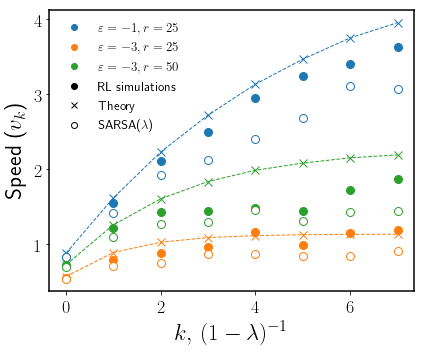

In [31]:
plt.close("all")
fig,axis = plt.subplots(1,1,figsize=(6,5))

for i in range(3):
    axis.plot(q_mems-1,vsarsas[i],'C%do'%i, ms = 8)
    axis.plot(q_mems-1,vpreds[i],'C%dx--'%i,ms= 8, lw = 1)
    axis.plot(q_mems-1,vlambdas[i],'C%do'%i,ms= 8, lw = 1, mfc = 'w')
    axis.plot([],[],'C%do'%i, label = r"$\varepsilon = %d, r = %d$"%(epss[i],rs[i]))
    
axis.plot([],[],'ko',label = "RL simulations")
axis.plot([],[],'kx',label = "Theory")
axis.plot([],[],'ko',mfc = 'w',label = r"SARSA($\lambda$)")
    
axis.legend(fontsize = 13, frameon=False)
axis.tick_params(labelsize = 18)
axis.set_xlabel(r"$k,$  $(1-\lambda)^{-1}$",fontsize = 23)
axis.set_ylabel(r"Speed ($v_k$)",fontsize = 23)
for sp in ['top','bottom','left','right']:
    axis.spines[sp].set_linewidth(1.5)
    
fig.tight_layout()
fig.savefig("./plots/et_speed_k.pdf")
plt.show()

### Get front shape 

In [185]:
np.random.seed(0)

r = 50
L = 100
alpha = 0.025
N = int(1.25*L/alpha)
eps = -3
eps2 = 10
q_mem = 4

qs,ss = get_qs_numerics(r,L,N,eps,eps2,q_mem = q_mem, alpha = alpha)
vnum = get_speed_numerics(L,eps,eps2,r, alpha = alpha, gam = 1, q_mem = q_mem, plot = False)

1.5 0.5502430377712836 0.15606625030556717 0.5040803686105282 8.761921929913665 0.019668054750461482


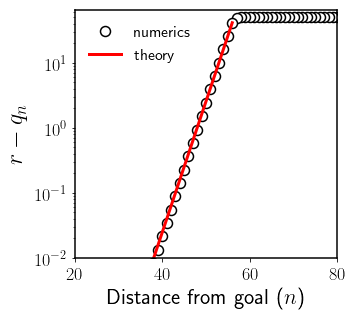

In [200]:
e = int(30/alpha)
qse = qs[:,e]
ns = np.arange(len(qse))
ind = np.argmax(ns[qse<abs(eps)])

k = q_mem - 1
lf = get_lf((1+k)/vnum)

front = r - (r - qse[ind+1])*(lf**((ns[ind+1:]-ns[ind+1])/(1+k)))
print(tau,1/vnum,lf, qse[ind],qse[ind+1], qse[ind-1] )

plt.close("all")
fig,axis = plt.subplots(1,1,figsize=(5,4.5))
axis.semilogy(L-ns,r-qse,'ko', mfc = 'w', mew = 1.5,ms = 10,label = "numerics")
axis.semilogy(L-ns[ind+1:], r-front, 'r-', lw = 3, label = "theory")
#axis.semilogy([ind,ind],[0,r],'k--')
axis.set_ylim(0.01,r*1.3)
axis.set_xlim(20,80)
axis.tick_params(labelsize = 18)
axis.set_xlabel(r"Distance from goal ($n$)", fontsize = 22)
axis.set_ylabel(r"$r - q_n$", fontsize = 24)
for sp in ['top','bottom','left','right']:
    axis.spines[sp].set_linewidth(1.5)
axis.legend(fontsize = 16, frameon=False)
fig.tight_layout()
fig.savefig("./plots/et_front_shape_k3.pdf")
plt.show()

### Dyna: measure speeds

In [180]:
np.random.seed(0)

# Learning parameters
alpha = 0.00625 #learning rate
gam = 0.9999 #discount factor
rew = 25

eps2 = 10
L = 25 #length of track
lamb = 1.0 - 1e-5 #eligibility traces
q_mem = 1
mode = 3
niter = 50000 #large enough that agent reaches reward in each episode. 
nepi = int(4*L/alpha) #large enough that learning converges. 
#the simulation automatically stops when the wave reaches the start.

epss = [-2,2]
n_ds = np.array([0,1,2,3,4,5])
vdynas = np.zeros((len(epss),len(n_ds)))
for j,eps in enumerate(epss):
    for i,n_d in enumerate(n_ds):
        G, Qrs, time_rews, cum_rews = run_RL_simulation(nepi,niter,L,lamb = lamb,\
                                alpha = alpha,gam=gam,rew = rew,mode=mode, eps=eps,eps2=eps2, \
                                                        dyna_plan_steps = n_d, q_mem_size = 1, dyna_mem_size = 500)
        time_paths, cum_paths = get_direct_paths(time_rews,L)

        #Measure speed of wave. 
        nepi = len(Qrs)
        mins = np.argmin(np.abs(Qrs[int(0.1*nepi):,:,0,0] - np.max(Qrs[int(0.1*nepi):,:,0,0],axis=1)[:,None]/2),axis=1)
        p = np.polyfit(np.arange(len(mins[1:])),mins[1:],1)
        vsim = -p[0]/alpha
        vdynas[j,i]= vsim
        print(eps, n_d, vsim)

-2 0 0.760097205481049
-2 1 1.4964660170747968
-2 2 2.1977359771568703
-2 3 2.8815481389539612
-2 4 3.477917418932726
-2 5 4.130783617669789
2 0 0.8753927121984204
2 1 1.9328064828043068
2 2 2.968770388412857
2 3 3.993378679951686
2 4 4.9378368125859
2 5 5.946139899532044


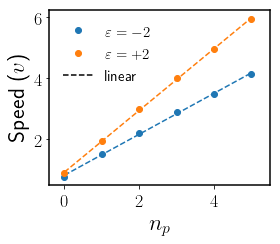

In [184]:
plt.close("all")
fig,axis = plt.subplots(1,1,figsize = (4,3.5))
axis.plot(n_ds, vdynas[0], 'C0o', label = r"$\varepsilon = -2$")
p = np.polyfit(n_ds,vdynas[0],1)
axis.plot(n_ds, p[0]*n_ds + p[1], 'C0--')

axis.plot(n_ds, vdynas[1], 'C1o', label = r"$\varepsilon = +2$")
p = np.polyfit(n_ds,vdynas[1],1)
axis.plot(n_ds, p[0]*n_ds + p[1], 'C1--')

axis.plot([],[], 'k--',label = "linear")

axis.legend(fontsize = 15, frameon=False)
axis.tick_params(labelsize = 18)
axis.set_xlabel(r"$n_p$",fontsize = 23)
axis.set_ylabel(r"Speed ($v$)",fontsize = 23)
for sp in ['top','bottom','left','right']:
    axis.spines[sp].set_linewidth(1.5)
axis.set_xlim(-0.4,n_ds[-1]+0.5)
fig.tight_layout()
fig.savefig("./plots/dyna_speeds.pdf")
plt.show()

### Q-learning 

In [146]:
np.random.seed(0)

# Learning parameters
alpha = 0.025 #learning rate
gam = 0.9999 #discount factor
eps2 = 10
L = 25 #length of track
lamb = 1.0 - 1e-5 #eligibility traces
q_mem = 1
mode = 1
niter = 50000 #large enough that agent reaches reward in each episode. 
nepi = int(6*L/alpha) #large enough that learning converges. 
#the simulation automatically stops when the wave reaches the start.

epss = np.linspace(-4,6,12)
rs = np.array([10,25,50])
vqs = np.zeros((len(epss),len(rs)))
for j,eps in enumerate(epss):
    for i,rew in enumerate(rs):
        G, Qrs, time_rews, cum_rews = run_RL_simulation(nepi,niter,L,lamb = lamb,\
                                alpha = alpha,gam=gam,rew = rew,mode=mode, eps=eps,eps2=eps2, \
                                                        dyna_plan_steps = n_d, q_mem_size = 1, dyna_mem_size = 500)
        time_paths, cum_paths = get_direct_paths(time_rews,L)

        #Measure speed of wave. 
        nepi = len(Qrs)
        mins = np.argmin(np.abs(Qrs[int(0.1*nepi):,:,0,0] - np.max(Qrs[int(0.1*nepi):,:,0,0],axis=1)[:,None]/2),axis=1)
        p = np.polyfit(np.arange(len(mins[1:])),mins[1:],1)
        vsim = -p[0]/alpha
        vqs[j,i]= vsim
        print(eps, rew, vsim)

-4.0 10 0.14596614554423776
-4.0 25 0.2690924064188823
-4.0 50 0.37563590264229857
-3.090909090909091 10 0.27802187195117567
-3.090909090909091 25 0.485811550672627
-3.090909090909091 50 0.5909220244657623
-2.1818181818181817 10 0.5206837951507657
-2.1818181818181817 25 0.7119588745684174
-2.1818181818181817 50 0.8462208814680146
-1.272727272727273 10 0.7294869512436171
-1.272727272727273 25 0.8906894399620926
-1.272727272727273 50 0.9450454311604163
-0.36363636363636376 10 0.8770738418419216
-0.36363636363636376 25 0.9545202618211135
-0.36363636363636376 50 0.9829002185178917
0.545454545454545 10 0.9522933644211865
0.545454545454545 25 0.9811984562029847
0.545454545454545 50 0.9923459771930838
1.4545454545454541 10 0.9823329925535554
1.4545454545454541 25 0.9949532940670963
1.4545454545454541 50 0.9949644930846127
2.3636363636363633 10 0.9893466971293087
2.3636363636363633 25 0.9960287877844239
2.3636363636363633 50 0.9968422376745047
3.2727272727272725 10 0.9953921441512057
3.2727272

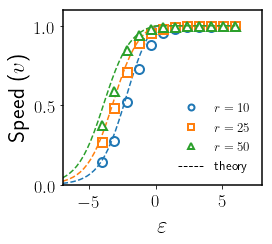

In [150]:
plt.close("all")
fig,axis = plt.subplots(1,1,figsize= (4,3.5))
markers = ['o','s','^','>']
epss2 = np.linspace(-7,6,50)
#axis.plot(epss2, ,'k--', lw = 2.5,alpha= 1)
for i in range(len(rs)):
    r = rs[i]
    vpred = r/(r + np.exp(np.abs(epss2)) - 1)
    vpred = vpred*(epss2 < 0) + (epss2 >= 0)
    
    axis.plot(epss,vqs[:,i],'C%d'%i + markers[i]\
              ,ms = 9,mfc = 'w',mew=2)
    axis.plot(epss2, vpred,'C%d--'%i)
    axis.plot([],[],'C%d'%i + markers[i]\
              ,ms = 6,mfc = 'w',mew=2, label = r"$r = %d$"%rs[i])
    
axis.plot([],[],'k--', lw = 1, label = "theory")
axis.legend(fontsize = 13, frameon=False)
axis.set_ylim(0,1.1)
axis.set_xlim(-7,8)
axis.tick_params(labelsize = 18)
axis.set_xlabel(r"$\varepsilon$",fontsize = 23)
axis.set_ylabel(r"Speed ($v$)",fontsize = 23)
for sp in ['top','bottom','left','right']:
    axis.spines[sp].set_linewidth(1.5)
fig.tight_layout()
fig.savefig("./plots/qlearning_speed_sim_theory_comparison.pdf")
plt.show()


### Q-learning (pure exploration) 

In [172]:
np.random.seed(0)

# Learning parameters
alpha = 0.05 #learning rate
gam = 0.9999 #discount factor
L = 25 #length of track
rew = 50
lamb = 1.0 - 1e-5 #eligibility traces
q_mem = 1
mode = 4
niter = 50000 #large enough that agent reaches reward in each episode. 
nepi = int(6*L/alpha) #large enough that learning converges. 
#the simulation automatically stops when the wave reaches the start.

epss = np.linspace(-4,5,10)
eps2s = np.array([4.5,3,1.5])
vqexplos = np.zeros((len(epss),len(eps2s)))
for j,eps in enumerate(epss):
    for i,eps2 in enumerate(eps2s):
        G, Qrs, time_rews, cum_rews = run_RL_simulation(nepi,niter,L,lamb = lamb,\
                                alpha = alpha,gam=gam,rew = rew,mode=mode, eps=eps,eps2=eps2, \
                                                        dyna_plan_steps = n_d, q_mem_size = 1, dyna_mem_size = 500)
        time_paths, cum_paths = get_direct_paths(time_rews,L)

        nepi = len(Qrs)
        mins = np.argmin(np.abs(Qrs[int(0.1*nepi):,:,0,0] - np.max(Qrs[int(0.1*nepi):,:,0,0],axis=1)[:,None]/2),axis=1)
        p = np.polyfit(np.arange(len(mins[1:])),mins[1:],1)
        vsim = -p[0]/alpha
        vqexplos[j,i]= vsim
        print(eps, eps2, vsim)

-4.0 4.5 0.008434548495098839
-4.0 3.0 0.00805542898605966
-4.0 1.5 0.01883310157154012
-3.0 4.5 0.040999642370603065
-3.0 3.0 0.049578866132014156
-3.0 1.5 0.07828120852064334
-2.0 4.5 0.1205023144289015
-2.0 3.0 0.1322170071622621
-2.0 1.5 0.19546188076545562
-1.0 4.5 0.27456525311357366
-1.0 3.0 0.28466341534470824
-1.0 1.5 0.38775390244193586
0.0 4.5 0.5044990004656287
0.0 3.0 0.5183264798997277
0.0 1.5 0.6237353371202577
1.0 4.5 0.7265846365173068
1.0 3.0 0.7482771251247835
1.0 1.5 0.8392053436274708
2.0 4.5 0.8726483802504051
2.0 3.0 0.8817030773665502
2.0 1.5 0.9318179156349268
3.0 4.5 0.956490122409405
3.0 3.0 0.9569758925754152
3.0 1.5 0.9699420874168692
4.0 4.5 0.9831094416729621
4.0 3.0 0.9800298522213824
4.0 1.5 0.9877764818681025
5.0 4.5 0.9942899141612177
5.0 3.0 0.9888594628904114
5.0 1.5 0.9922802798549691


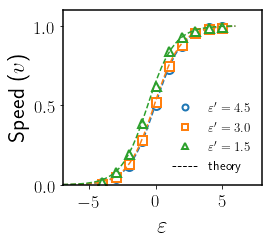

In [177]:
pp,pn = get_pp_pn(epss,eps2,0)

plt.close("all")
fig,axis = plt.subplots(1,1,figsize= (4,3.5))
markers = ['o','s','^','>']
epss2 = np.linspace(-7,6,50)
#axis.plot(epss2, ,'k--', lw = 2.5,alpha= 1)
for i in range(len(eps2s)):
    eps2 = eps2s[i]
    pp,pn = get_pp_pn(epss2,eps2,0)
    vpred = sig(epss2)*(1-pn)/(pp-pn)
    
    axis.plot(epss,vqexplos[:,i],'C%d'%i + markers[i]\
              ,ms = 9,mfc = 'w',mew=2)
    
    axis.plot(epss2, vpred,'C%d--'%i)
    
    axis.plot([],[],'C%d'%i + markers[i]\
              ,ms = 6,mfc = 'w',mew=2, label = r"$\varepsilon' = %.1f$"%eps2s[i])
    
axis.plot([],[],'k--', lw = 1, label = "theory")
axis.legend(fontsize = 13, frameon=False)
axis.set_ylim(0,1.1)
axis.set_xlim(-7,8)
axis.tick_params(labelsize = 18)
axis.set_xlabel(r"$\varepsilon$",fontsize = 23)
axis.set_ylabel(r"Speed ($v$)",fontsize = 23)
for sp in ['top','bottom','left','right']:
    axis.spines[sp].set_linewidth(1.5)
fig.tight_layout()
fig.savefig("./plots/qexplo_speed_sim_theory_comparison.pdf")
plt.show()

1.524131591025766


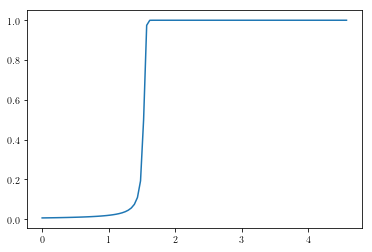

In [26]:
eps_abs = 5
r = 100
tmax = (eps_abs + np.exp(eps_abs) - 1)/r
ts = np.linspace(0,3*tmax,100)
print(tmax)
rate = 1/(1 + lambertw(np.exp(eps_abs + np.exp(eps_abs) - r*ts),0).real)

plt.close("all")
plt.plot(ts,rate)
plt.show()

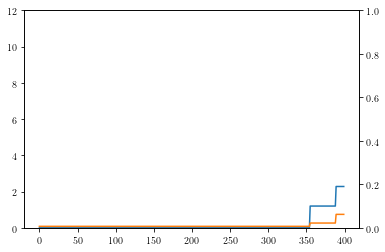

In [123]:
alpha = 1e-1
q = 0
eps = -5
r = 12
N = 400
qs = np.zeros(N)

f = 0.5

for i in range(1,N):
    if np.random.uniform() < sig(qs[i-1] + eps):
        if np.random.uniform() < f:
            delta  = r - qs[i-1]
        else:
            delta = -qs[i-1]
    else:
        delta = 0
        
    qs[i] = qs[i-1] + alpha*delta
    
plt.close("all")
plt.plot(qs)
plt.ylim(0,r)
plt.twinx().plot(sig(qs+eps),'C1')
plt.ylim(0,1)
plt.show()